In [5]:
import pandas as pd
import os
from shapely.geometry import Point, Polygon

cwd =os.getcwd()

### Structure socioeconomic data by year

In [248]:
socioeco_df = pd.read_excel(cwd+'/socioeconomic_data/socioeco_data.xlsx', sheet_name = 3)

postnr_columns =['POSTNR', 'YEAR', 'KOMKODE', 'SALGSPRIS']
kom_columns = ['KOMKODE', 'YEAR', 'DISINDK', 'KRIMINELITET', 'LAVINDK', 'SKILSMISSER', 'ANDEL_INDV']

post_df = socioeco_df[postnr_columns]
kom_df = socioeco_df[kom_columns]

years = [2011, 2015, 2019]
post_split = [post_df[post_df['YEAR'] == year] for year in years]
kom_split = [kom_df[kom_df['YEAR'] == year] for year in years]

In [201]:
post_split[2]

,POSTNR,YEAR,KOMKODE,SALGSPRIS
2841,1000,2019,101,NaN
2842,1050,2019,101,NaN
2843,1051,2019,101,NaN
2844,1052,2019,101,NaN
2845,1053,2019,101,NaN
...,...,...,...,...
4259,9970,2019,813,7705.0
4260,9981,2019,813,NaN
4261,9982,2019,813,6225.0
4262,9982,2019,860,6225.0


### Merge school data and socioeconomic data by postal code and kommune

In [253]:
df_list = []
for data, year in zip(post_split, [2011, 2015, 2019]):
    # load data
    soc_data = data
    school_data = pd.read_csv(cwd+f'/school_data/school_clean_{year-1}-{year}.csv', index_col=0)

    # merge data
    merged = pd.merge(left = school_data, right = soc_data, left_on = ['beliggenhedskommunenr', 'postnr'], right_on = ['KOMKODE', 'POSTNR'])

    # format
    merged.columns = merged.columns.str.lower()
    merged = merged.T.drop_duplicates().T

    merged.to_csv(f'postnr_background_vars{year}.csv')

    df_list.append(merged)

for data, year in zip(kom_split, [2011, 2015, 2019]):
    data.drop_duplicates()\
        .to_csv(f'kom_background_vars{year}.csv')

In [42]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
import pyproj


In [204]:
# Well, that was horrible...
# conda remove pyproj
# pip install pyproj
# conda install geopandas 

# Læs baggrundsvariable of oversæt til utm
df = pd.read_csv('postnr_background_vars2019.csv', index_col=0)

c = [Point(x, y) for x, y in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry = c)

gdf.crs = {'init': 'epsg:4326'}
gdf_utm = gdf.to_crs(epsg = 32632)

# frasorter efterskoler (behold privat- og friskoler for at undgå for stort fald i antal observationer)
gdf_utm = gdf_utm[gdf_utm['institutionstype2'] == 'Grundskoler']

In [205]:
# Læs valgdistrikter og tilføj centroid
valg_distrikt = gpd.read_file(cwd+'\scrape_geodata\geodata\dagi_10m_nohist_l1.afstemningsomraade\\afstemningsomraade.shp', driver = 'ESRI Shapefile')
valg_distrikt['centroid']=valg_distrikt['geometry'].centroid

In [207]:
valg_geo = valg_distrikt.set_geometry('centroid')
schools_geo = gdf_utm.geometry.unary_union

<AxesSubplot:>

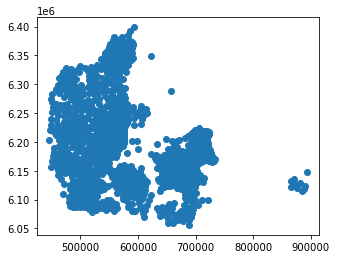

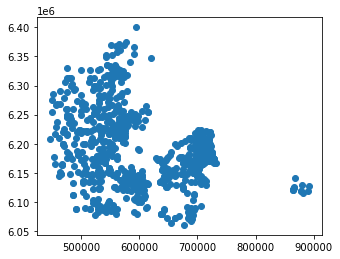

In [208]:
valg_geo.plot()
gdf_utm.plot()

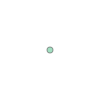

In [209]:
# Find for hver centroid den nærmeste skole
# For valg_distrikt['c½entroid'] find nærmeste gdf_utm['geometry'] ogtilføj tilhørende 'institutionsnummer'
pts3 = gdf_utm.geometry.unary_union
def near(point, pts = pts3):
    nearest = gdf_utm.geometry == nearest_points(point, pts)[1]
    return gdf_utm[nearest]['institutionsnummer'].values[0]
    
valg_geo['institutionsnummer'] = valg_geo.apply(lambda row: near(row.geometry), axis = 1)
nearest

In [154]:
test_valg = valg_geo.iloc[0].centroid

nearest = nearest_points(test_valg, schools_geo)[1]
print(test_valg)
print(nearest)
gdf_utm[gdf_utm['geometry'] == nearest]

POINT (451656.6997033993 6268814.209849044)
POINT (456980.0400001348 6266591.919793459)


,institutionsnummer,karakter,soc_ref,beliggenhedskommunenr,lat,lon,postnr,navn,institutionstype2,institutionstype3,...,komnavn,year,salgspris,disindk,langledig,kriminelitet,lavindk,skilsmisser,andel_indv,geometry
949,665002,7.2,6.8,665,56.541707,8.300398,7620,Christinelystskolen,Grundskoler,Folkeskoler,...,Lemvig Kommune,2019,5849.0,217221,0.291667,3.0,14.8,10.6,3.653696,POINT (456980.040 6266591.920)


In [223]:
# merge election to school in 'intitutionsnummer
merge1 = pd.merge(left=valg_geo, right = gdf_utm, on = 'institutionsnummer')
merge1.columns

Index(['objectid', 'id_lokalid', 'id_namespa', 'status', 'geometrist',
       'virkningfr', 'virkningti', 'virkningsa', 'forretning', 'registreri',
       'registre00', 'registre01', 'forretni00', 'forretni01', 'dagiid',
       'navn_x', 'redigering', 'dataspecif', 'landekode', 'skala',
       'afstemning', 'afstemni00', 'afstemni01', 'kommunekod', 'kommunelok',
       'opstilling', 'opstilli00', 'udtraeksda', 'gmlid', 'geometry_x',
       'centroid', 'institutionsnummer', 'karakter', 'soc_ref',
       'beliggenhedskommunenr', 'lat', 'lon', 'postnr', 'navn_y',
       'institutionstype2', 'institutionstype3', 'coordinates', 'year',
       'salgspris', 'geometry_y'],
      dtype='object')

In [229]:
# merge merge1 to mapping on 'objectid'
mapping = pd.read_csv(cwd+'/scrape_geodata/mapping_geodata_v3.csv', sep =';')
mapping.objectid = mapping.objectid.astype(str)
merge2 = pd.merge(left = merge1, right = mapping[['objectid', 'refs']], on = 'objectid')
merge2

,objectid,id_lokalid,id_namespa,status,geometrist,virkningfr,virkningti,virkningsa,forretning,registreri,...,lon,postnr,navn_y,institutionstype2,institutionstype3,coordinates,year,salgspris,geometry_y,refs
0,1285591,711178,http://data.gov.dk/dagi,vedtaget,endelig,20181127000000,None,Andet,systemetablering,20181127115950.448,...,8.300398,7620,Christinelystskolen,Grundskoler,Folkeskoler,"(56.5417072334074, 8.300397891210551)",2019,5849.0,POINT (456980.040 6266591.920),F901665003.htm
1,1285619,711172,http://data.gov.dk/dagi,vedtaget,endelig,20181127000000,None,Andet,systemetablering,20181127115950.448,...,8.300398,7620,Christinelystskolen,Grundskoler,Folkeskoler,"(56.5417072334074, 8.300397891210551)",2019,5849.0,POINT (456980.040 6266591.920),F901665004.htm
2,1285631,706536,http://data.gov.dk/dagi,vedtaget,endelig,20181127000000,None,Andet,systemetablering,20181127115950.448,...,8.300398,7620,Christinelystskolen,Grundskoler,Folkeskoler,"(56.5417072334074, 8.300397891210551)",2019,5849.0,POINT (456980.040 6266591.920),F901665001.htm
3,1295999,706714,http://data.gov.dk/dagi,vedtaget,endelig,20190429000000,None,Andet,systemetablering,20190429145414.863,...,9.723181,5500,Fænøsund Friskole,Grundskoler,Friskoler og private grundskoler,"(55.499902107147705, 9.72318121375711)",2019,13679.0,POINT (545683.475 6150659.929),F605410001.htm
4,1285601,701882,http://data.gov.dk/dagi,vedtaget,endelig,20181127000000,None,Andet,systemetablering,20181127115950.448,...,8.178329,7673,Harboøre Skole og Børnecenter,Grundskoler,Folkeskoler,"(56.6178540439447, 8.17832922896946)",2019,3384.0,POINT (449575.430 6275150.450),F901665008.htm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379,1303228,712204,http://data.gov.dk/dagi,vedtaget,endelig,20190612000000,None,Andet,systemetablering,20190612113851.354,...,11.746338,4700,Herlufsholm Skole og Gods,Grundskoler,Friskoler og private grundskoler,"(55.2458162, 11.74633787)",2019,11879.0,POINT (674580.150 6125584.880),F504370026.htm
1380,1306341,703948,http://data.gov.dk/dagi,vedtaget,endelig,20191217000000,None,Andet,systemetablering,20191217141245.217,...,10.113277,8381,Tilst Skole,Grundskoler,Folkeskoler,"(56.189536015882204, 10.113277148416598)",2019,16376.0,POINT (569090.820 6227732.500),F802751028.htm
1381,1306371,709972,http://data.gov.dk/dagi,vedtaget,endelig,20191217000000,None,Andet,systemetablering,20191217141245.217,...,10.229043,8240,Risskov Skole,Grundskoler,Folkeskoler,"(56.192965125566595, 10.2290432602524)",2019,28543.0,POINT (576268.150 6228236.160),F804751045.htm
1382,1306648,702938,http://data.gov.dk/dagi,vedtaget,endelig,20200101000000,None,Geodatastyrelsen,ændretBekendtgørelse,20200108132505.108,...,9.346793,8800,Hald Ege Fri- og Efterskole,Grundskoler,Friskoler og private grundskoler,"(56.411417510544005, 9.34679331044587)",2019,12628.0,POINT (521398.360 6251924.723),F903791002.htm


In [266]:
# merge to election results
election_result = pd.read_csv(cwd+'/scrape_geodata/data2019.csv')

merge3 = pd.merge(left = merge2, right = election_result, on = 'refs')
merge3.kommunekod = merge3.kommunekod.astype(int).astype(str)
merge3.kommunekod

0        665
1        665
2        665
3        665
4        665
        ... 
19510    480
19511    480
19512    480
19513    480
19514    480
Name: kommunekod, Length: 19515, dtype: object

In [270]:
# merge to background vars on kommune level
background = pd.read_csv('kom_background_vars2019.csv', index_col = 0)

background.KOMKODE = background.KOMKODE.astype(str)
background

all_2019 = pd.merge(left = merge3, right = background, left_on = 'kommunekod', right_on = 'KOMKODE')
all_2019.to_csv('all_2019.csv')


In [268]:
all_2019.columns

,objectid,id_lokalid,id_namespa,status,geometrist,virkningfr,virkningti,virkningsa,forretning,registreri,...,year_y,voting_area,municipality,KOMKODE,YEAR,DISINDK,KRIMINELITET,LAVINDK,SKILSMISSER,ANDEL_INDV
0,1285591,711178,http://data.gov.dk/dagi,vedtaget,endelig,20181127000000,None,Andet,systemetablering,20181127115950.448,...,2019,Klinkby,Lemvig Kommune,665,2019.0,217221.0,3.0,14.8,10.6,3.653696
1,1285591,711178,http://data.gov.dk/dagi,vedtaget,endelig,20181127000000,None,Andet,systemetablering,20181127115950.448,...,2019,Klinkby,Lemvig Kommune,665,2019.0,217221.0,3.0,14.8,10.6,3.653696
2,1285591,711178,http://data.gov.dk/dagi,vedtaget,endelig,20181127000000,None,Andet,systemetablering,20181127115950.448,...,2019,Klinkby,Lemvig Kommune,665,2019.0,217221.0,3.0,14.8,10.6,3.653696
3,1285591,711178,http://data.gov.dk/dagi,vedtaget,endelig,20181127000000,None,Andet,systemetablering,20181127115950.448,...,2019,Klinkby,Lemvig Kommune,665,2019.0,217221.0,3.0,14.8,10.6,3.653696
4,1285591,711178,http://data.gov.dk/dagi,vedtaget,endelig,20181127000000,None,Andet,systemetablering,20181127115950.448,...,2019,Klinkby,Lemvig Kommune,665,2019.0,217221.0,3.0,14.8,10.6,3.653696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19510,1299127,703836,http://data.gov.dk/dagi,vedtaget,endelig,20190508000000,None,Andet,systemetablering,20190508012439.499,...,2019,Holmegårdshallen,Hvidovre Kommune,167,2019.0,229211.0,5.7,24.6,13.0,15.673518
19511,1299127,703836,http://data.gov.dk/dagi,vedtaget,endelig,20190508000000,None,Andet,systemetablering,20190508012439.499,...,2019,Holmegårdshallen,Hvidovre Kommune,167,2019.0,229211.0,5.7,24.6,13.0,15.673518
19512,1299127,703836,http://data.gov.dk/dagi,vedtaget,endelig,20190508000000,None,Andet,systemetablering,20190508012439.499,...,2019,Holmegårdshallen,Hvidovre Kommune,167,2019.0,229211.0,5.7,24.6,13.0,15.673518
19513,1299127,703836,http://data.gov.dk/dagi,vedtaget,endelig,20190508000000,None,Andet,systemetablering,20190508012439.499,...,2019,Holmegårdshallen,Hvidovre Kommune,167,2019.0,229211.0,5.7,24.6,13.0,15.673518


In [59]:
# Find centroids pr valgsted DONE
# Find for hver centroid den nærmeste skole DONE
# Lav column med institutionsnummer for nærmeste skole DONE
# Merge valgdistrikter med skoledata på institutionsnummer DONE
# Merge på mapping fil på objectid DONE
# merge på valgresultater fra 2019 på refs DONE
# split i kommune og postnnr DONE
# ryd op i data - kollaps valgresultater
# ryd op i kode
# tilføj huspriser for kbhk